In [ ]:
import numpy as np
import tensorflow as tf
import joblib
import os
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from sklearn.metrics import accuracy_score

print(f"TensorFlow Version: {tf.__version__}")
if not tf.executing_eagerly():
    print("⚠ WARNING: Eager execution is OFF. This might cause issues with ART.")
else:
    print("✓ Eager execution is ON.")

TensorFlow Version: 2.20.0
✓ Eager execution is ON.


In [ ]:
print("Loading training data...")

try:
    X_train = np.load('X_train_ids.npy')
    y_train_ohe = np.load('y_train_ids_ohe.npy')
    print(f"✓ Training data loaded. Shape: {X_train.shape}")
except FileNotFoundError:
    print("Error: Training data not found. Please run the 'Save Data' cell in your Baseline Notebook.")

try:
    model = load_model('ids_model.h5')
    print("✓ Baseline model loaded.")
except:
    print("Error: ids_model.h5 not found.")

Loading training data...


✓ Training data loaded. Shape: (845244, 78, 1)
✓ Baseline model loaded.


In [ ]:
classifier = KerasClassifier(model=model, clip_values=(X_train.min(), X_train.max()))

print("\nGenerating adversarial examples for training...")
print("This creates a 'vaccine' to harden the model.")

n_vaccine = 50000
X_vaccine_clean = X_train[:n_vaccine]
y_vaccine_labels = y_train_ohe[:n_vaccine]

attacker = FastGradientMethod(estimator=classifier, eps=0.1)
X_vaccine_adv = attacker.generate(x=X_vaccine_clean)

print("✓ Adversarial vaccine generated.")


Generating adversarial examples for training...
This creates a 'vaccine' to harden the model.


/Users/mahima/Desktop/ENC/env/lib/python3.12/site-packages/art/estimators/classification/keras.py:305: UserWarning: Loss function is a plain function, not a Keras loss object. Cannot set reduction; assuming per-sample loss.
  warnings.warn(


✓ Adversarial vaccine generated.


In [ ]:
print("\nCreating hardened dataset...")

X_train_at = np.concatenate([X_train, X_vaccine_adv], axis=0)
y_train_at = np.concatenate([y_train_ohe, y_vaccine_labels], axis=0)

indices = np.arange(len(X_train_at))
np.random.shuffle(indices)
X_train_at = X_train_at[indices]
y_train_at = y_train_at[indices]

print(f"New Training Set Shape: {X_train_at.shape}")

print("\nTraining Defended Model...")
n_features = X_train.shape[1]
n_classes = y_train_ohe.shape[1]

model_at = Sequential([
    Input(shape=(n_features, 1)),
    Conv1D(128, 3, activation='relu', padding='same'),
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(256, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

model_at.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_at.fit(X_train_at, y_train_at, epochs=5, batch_size=128, validation_split=0.1)

model_at.save('ids_model_at.h5')
print("\n✓ Defended model saved as 'ids_model_at.h5'")


Creating hardened dataset...
New Training Set Shape: (895244, 78, 1)

Training Defended Model...
Epoch 1/5
6295/6295 ━━━━━━━━━━━━━━━━━━━━ 222s 35ms/step - accuracy: 0.9603 - loss: 0.1206 - val_accuracy: 0.9701 - val_loss: 0.0821
Epoch 2/5
6295/6295 ━━━━━━━━━━━━━━━━━━━━ 222s 35ms/step - accuracy: 0.9698 - loss: 0.0879 - val_accuracy: 0.9733 - val_loss: 0.0730
Epoch 3/5
6295/6295 ━━━━━━━━━━━━━━━━━━━━ 214s 34ms/step - accuracy: 0.9714 - loss: 0.0822 - val_accuracy: 0.9744 - val_loss: 0.0710
Epoch 4/5
6295/6295 ━━━━━━━━━━━━━━━━━━━━ 219s 35ms/step - accuracy: 0.9725 - loss: 0.0794 - val_accuracy: 0.9751 - val_loss: 0.0694
Epoch 5/5
6295/6295 ━━━━━━━━━━━━━━━━━━━━ 216s 34ms/step - accuracy: 0.9730 - loss: 0.0770 - val_accuracy: 0.9774 - val_loss: 0.0658



✓ Defended model saved as 'ids_model_at.h5'


In [ ]:
attack_files = {
    'FGSM': ('X_adv_fgsm_ids.npy', 'y_test_fgsm_ids_int.npy'),
    'PGD':  ('X_adv_pgd_ids.npy',  'y_test_pgd_ids_int.npy'),
    'C&W':  ('X_adv_cw_ids.npy',   'y_test_cw_ids_int.npy')
}

baseline_scores = {
    'FGSM': 62.29,
    'PGD':  34.43,
    'C&W':  44.92
}

print("\n" + "="*60)
print("ADVERSARIAL TRAINING EVALUATION RESULTS")
print("="*60)
print(f"{'Attack':<10} {'Baseline':<12} {'Defended':<12} {'Improvement':<12}")
print("-" * 60)

at_scores = {}

for name, (x_file, y_file) in attack_files.items():
    try:
        X_adv = np.load(x_file)
        y_true = np.load(y_file)
        
        y_pred = np.argmax(model_at.predict(X_adv, verbose=0), axis=1)
        acc = accuracy_score(y_true, y_pred) * 100
        at_scores[name] = acc
        
        base = baseline_scores.get(name, 0)
        imp = acc - base
        
        print(f"{name:<10} {base:<12.2f}% {acc:<12.2f}% +{imp:<12.2f}%")
        
    except FileNotFoundError:
        print(f"{name:<10} -- File not found --")


ADVERSARIAL TRAINING EVALUATION RESULTS
Attack     Baseline     Defended     Improvement 
------------------------------------------------------------
FGSM       62.29       % 97.07       % +34.78       %
PGD        34.43       % 84.89       % +50.46       %
C&W        44.92       % 88.40       % +43.48       %


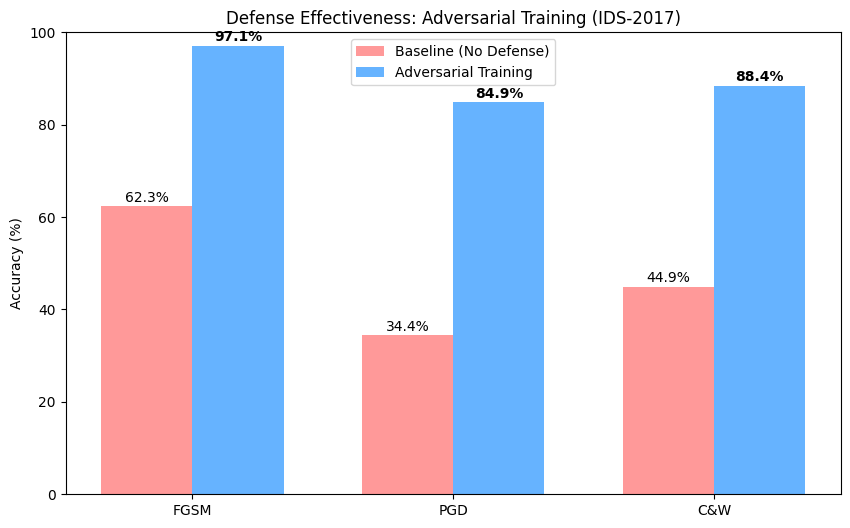

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

attacks = list(at_scores.keys())
baseline_vals = [baseline_scores[a] for a in attacks]
defended_vals = [at_scores[a] for a in attacks]

plt.figure(figsize=(10, 6))
x = np.arange(len(attacks))
width = 0.35

plt.bar(x - width/2, baseline_vals, width, label='Baseline (No Defense)', color='#ff9999')
plt.bar(x + width/2, defended_vals, width, label='Adversarial Training', color='#66b3ff')

plt.ylabel('Accuracy (%)')
plt.title('Defense Effectiveness: Adversarial Training (IDS-2017)')
plt.xticks(x, attacks)
plt.legend()
plt.ylim(0, 100)

for i, v in enumerate(baseline_vals):
    plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
for i, v in enumerate(defended_vals):
    plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')

plt.show()